In [ ]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import time
import os

# import synthetic dataset generator
import sys
sys.path.insert(1, '..\\data\\raw')
from synthetic_baumann import create_synth # copied from https://github.com/rcrupiISP/BiasOnDemand

In [22]:
import seaborn as sns
sns.set()
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
paper_rc = {'lines.linewidth': 1, 'lines.markersize': 7} 
sns.set_context(font_scale=1.4) # , rc=paper_rc, 'paper'

font = {'family' : 'Times New Roman',
        'size'   : 18}
plt.rc('font', **font)

In [23]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

## 1. Theory

### 1.1. Fuzzy rough set model

Let us assume that we have a universe of discourse $U$, a fuzzy set $X \subseteq U$ and a fuzzy binary relation $R \subseteq U \times U$ such that $\mu_{X}(x)$ and $\mu_{R}(y,x)$ are their membership functions, respectively. The membership function $\mu_R : U \rightarrow [0,1]$ determines the degree to which $x \in U$ is a member of $X$, whereas $\mu_R : U \times U \rightarrow [0,1]$ denotes the degree to which $y$ is considered to be a member of $X$ from the fact that $x$ is a member of the fuzzy set $X$. Whenever opportune, $R(x)$ is denoted with its membership function $\mu_{R(x)}(y) = \mu_{R}(y,x)$.

Firstly, let us build a partition of $U$ according to the decision classes. The $X_{k}$ set contains all objects associated with the $k$-th decision class. The membership degree of $x \in U$ to a subset $X_{k}$ was computed using the following hard membership function: $\mu_{X_{k}}(x) = 1$ for $x \in X_{k}$ and $\mu_{X_{k}}(x) = 0$ for $x \not\in X_{k}$, as we assume that all problem instances are correctly labeled. 

Secondly, we define a fuzzy binary relation $\mu_{R}(y,x)$ to determine the fuzzy similarity between instances $x$ and $y$. This function should combine the membership degree $\mu_{X_{k}}(x)$ with the similarity degree $\phi(x,y)$ between two objects $x, y \in U$. Overall, we define $\mu_{R}(y,x) = \phi(x,y)$.

The similarity degree is defined as

$\phi(x,y) = e^{-\lambda \big( d(x,y) \big)}$

where $\lambda > 0$ is a user-specified smoothing parameter to avoid saturation problems in which similarity values have low variability even for quite dissimilar instances. $d$ is a user specified distance function which is defined in part 1.2 of this notebook.

To compute fuzzy-rough sets we use the definition of Radzikowska & Kerre (2002, Definition 4) [1] who generalize the lower and upper approximation operators in a Pawlak approximation space. We use this fuzzy-rough set approach as defined in the work of D'eer et al. (2015). This definition is based on a conjunctor, an implicator and a binary fuzzy relation. Let $(U,R)$ be a *fuzzy approximation space*  that consists of a non-empty universe $U$ and a binary fuzzy relation $R$ on $U$. Let $A$ be a fuzzy set in $U$, $\mathcal{I}$ an implicator and $\mathcal{T}$ a conjunctor. The $(\mathcal{I},\mathcal{T})$-*fuzzy rough approximation* of $A$ by $R$ is the pair of fuzzy sets ($\underline{\rm \text{apr}}^{\mathcal{I}}_{R}(A)$,$\overline{\rm \text{apr}}^{\mathcal{I}}_{R}(A)$). For $x \in U$:

 $(\underline{\rm \text{apr}}^{\mathcal{I}}_{R}(A))(x)=\underset{y \in U}{inf}\mathcal{I}(R(y,x),A(y))$,  
 $(\overline{\rm \text{apr}}^{\mathcal{T}}_{R}(A))(x)=\underset{y \in U}{sup}\mathcal{T}(R(y,x),A(y))$  

Source:  
[1] A.M. Radzikowska, E.E. Kerre, A comparative study of fuzzy rough sets, Fuzzy Sets and Systems 126, p. 137–156, 2002  
[2] D'eer, L., Verbiest, N., Cornelis, C., & Godo, L. (2015). A comprehensive study of implicator–conjunctor-based and noise-tolerant fuzzy rough sets: definitions, properties and robustness analysis. Fuzzy Sets and Systems, 275, 1-38.  

Finally, we define the fuzzy rough regions using the upper and lower approximations. The membership functions for the fuzzy rough positive, negative and boundary regions can be defined as 

$\mu_{POS(X_{k})}(x) = \mu_{R_{*}(X_{k})}(x)$  
$\mu_{NEG(X_{k})}(x) = 1 - \mu_{R^{*}(X_{k})}(x)$  
$\mu_{BND(X_{k})}(x) = \mu_{R^{*}(X_{k})}(x) - \mu_{R_{*}(X_{k})}(x)$  

Membership values to positive regions indicate the extent to which the instances belong to a decision class, membership values to negative regions indicate the extent to which the instances do not belong to a decision class, whereas membership values to boundary regions indicate the extent to which the instances are uncertain to the problem at hand.

### 1.2. Similarity or distance function (HEOM, HMOM, HVDM)

Let $F={f_{1},...,f{m}}$ be a set of features, where $f_{j}$ can be either numeric or nominal while $x(j)$ and $y(j)$ denote the values of the $j$-th feature according to instances $x$ and $y$, respectively. Thus, the dissimilarity between between two instances $x$ and $y$ can be computed as follows:

**Heterogeneous Manhattan-Overlap Metric** (HMOM)

$$d(x,y) =\sum_{j=1}^{|F|}\rho_{j}(x,y)$$    

such that  
    
$$\rho_{j}(x,y) = 
\begin{cases}
0\qquad\qquad\qquad\qquad if\enspace f_{j} \in F\enspace is\enspace nominal \wedge x(j) = y(j)\\
1\qquad\qquad\qquad\qquad  if\enspace f_{j} \in F\enspace is\enspace nominal \wedge x(j) \neq y(j)\\
\frac{|x(j) - y(j)|}{max_{j}-min_{j}}\qquad \qquad if\enspace f_{j} \in F\enspace is\enspace numeric
\end{cases}
$$

**Heterogeneous Euclidean-Overlap Metric** (HEOM)
$$d(x,y) =\sqrt{\sum_{j=1}^{|F|}\sigma_{j}(x,y)}$$
    
such that
    
$$\sigma_{j}(x,y) = \begin{cases}
0\qquad\qquad\qquad\qquad if\enspace f_{j} \in F\enspace is\enspace nominal \wedge x(j) = y(j)\\
1\qquad\qquad\qquad\qquad  if\enspace f_{j} \in F\enspace is\enspace nominal \wedge x(j) \neq y(j)\\
(\frac{x(j) - y(j)}{max_{j}-min_{j}})^{2}\qquad \qquad if\enspace f_{j} \in F\enspace is\enspace numeric
\end{cases}$$

**Heterogeneous Value Difference Metric** (HVDM)

$$d(x,y) =\sqrt{\sum_{j=1}^{|F|}\tau_{j}(x,y)}$$

such that
    
$$\tau_{j}(x,y) = \begin{cases}
\frac{1}{K}\sum^{K}_{k=1}(\frac{\beta_{f_{j},x(j),k}}{\beta_{f_{j},x(j)}}-\frac{\beta_{f_{j},y(j),k}}{\beta_{f_{j},y(j)}})\qquad if\enspace f_{j} \in F\enspace is\enspace nominal\\
(\frac{x(j) - y(j)}{max_{j}-min_{j}})^{2}\qquad \qquad \qquad \qquad if\enspace f_{j} \in F\enspace is\enspace numeric
\end{cases}$$

where $\beta_{f_{j},x(j)}$ is the number of instances that have value $x(j)$ for feature $f_{j}$, and $\beta_{f_{j},x(j),k}$ denotes the number of instances that have value $x_{j}$ for feature $f_{j}$ and output class $k$. In other words, HVDM measures the correlation between a feature and a decision class.

Finally, the following equation portrays the similarity function, which produces values in the $(0,1)$ interval, 

$$\phi(x,y) = e^{-\lambda \big( d(x,y) \big)}$$

where $\lambda > 0$ is a user-specified smoothing parameter to avoid saturation problems in which similarity values have low variability even for quite dissimilar instances. We use $\phi(x,y)$ as similarity function to compute the fuzzy-rough sets as defined by Radzikowska and Kerre (2002). To compute the fuzzy-rough sets as defined by Inuiguchi et al. (2015), $\phi(x,y)$ is multiplied by the $\mu_{X_{k}}(x)$ to make sure that we are comparing instances that are similarly classified ($\mu_{R}(y,x) = \mu_{X_{k}}(x) \phi(x,y)$). 

### 1.3. Bias measure: fuzzy rough uncertainty (FRU)

The FRU measure quantifies how much the absence of the sensitive feature $f_{i}$ modifies the fuzzy rough boundary regions. The difference can be both positive or negative. To quantify these differences, we use the membership values of instances in $U$ to the boundary regions using (i) the full set of features, and (ii) the set of features without the sensitive feature $f_{i}$ (denoted by $\neg f_{i}$). We use equation \eqref{eqn:FRU_L2} to compute the FRU value associated with the $k$-th decision class and the $i$-th sensitive feature, 

${\Omega}_{k}(f_{i}) = \sqrt{\frac{1}{|U|}\sum_{x \in U}{(\Delta_{B_{k}\neg f_{i}}(x))^2}}$

such that $\Delta_{B_{k}\neg f_{i}}(x) = \mu_{B_{k}}(x) - \mu_{B_{k} \neg f_{i}}(x)$ when the removal of the $i$-th feature increases or decreases the uncertainty. To lighten the notation, we denote the $k$-th boundary region $\mu_{BND(X_{k})}(x)$ with $\mu_{B_{k}}(x)$. It is also possible to divide the FRU by the sum of the FRU values of all features in the dataset, $\Omega_{k}(f_{i}) / \sum_{j}\Omega_k(f_j)$, such that the FRU values add up to one which makes their interpretation more meaningful. Overall, the proposed granular measure is similar to computing the relevance of the sensitive feature to preserve the decision boundaries attached to the problem. Note that in multiclass classification problems, the final FRU measure is the average FRU value of all decision classes if we normalize by their fuzzy cardinalities.

The FRU can also capture group fairness by quantifying the change in fuzzy rough boundary regions for the members of a group within a sensitive feature. We refer to this variant of the FRU as group-FRU. To quantify the changes in the boundary values per group, we divide the universe of discourse into a $G_j$ partition that consists of the instances of the $j$-th group in the sensitive feature $f_{i}$ for the $k$-th decision class. This implies that the sensitive feature $f_i$ is nominal and contains $\{2,..,p\}$ group-categories (such as females or males for the feature sex). The equation below computes the FRU value associated with a group $j$ of the $i$-th sensitive feature for the $k$-th decision class.  

$\Omega_{k,j}(f_{i}) = \sqrt{\frac{1}{|G_{j}|}\sum_{x \in G_{j}}{(\Delta_{B_{k}\neg f_{i}}(x))^2}}$  

Note that dividing with the total number of instances of group $j$ allows comparing groups of different sizes. We assume that the decision-making process is fair for all groups if their FRU values are similar. It is also possible to divide by the sum of all group-FRU values, $\widetilde{\Omega}_{k,j}(f_{i})=\Omega_{k,j}(f_{i}) / \sum_{p}\Omega_{k,p}(f_i)$, such that both add up to one.

## 2. Algorithms & computational performance

The first algorithm we create can be found below. It used loops which makes is relatively slow.

In [27]:
class FRS_loop:
    '''
    Slower version of the algorithm, loops through everything, kept it for validation reasons
    '''

    def __init__(self, dataset, a, im, con, frs_method, decision_class = None, fuzzy_decision_class = False):
        '''
        Initialized objects

        Parameters
        ----------
        alpha: float
            float between 0 and 1, parameter that separates the fuzzy-rough regions
        implication: string
            options are 'Luka', 'Godel', 'Fodor', 'Goguen'
        conjunction: string
            options are 'Standard', 'Algebraic', 'Luka', 'Drastic'
            choose 'radzikowska', 'inuiguchi' definition of fuzzy-rough sets
        '''
        self.X = dataset
        self.D = None
        self.im = im
        self.con = con
        self.p_att = None
        self.a = a
        self.frs_method = frs_method
        self.decision_class = decision_class
        self.fdc = fuzzy_decision_class

    def regions(self):
        
        # if no decision class is specified, then all will be computed
        if self.decision_class == None:
            self.D = np.unique(self.X[:,-1])

        # if a decision class is specified
        if self.decision_class != None:
            self.D = np.array([self.decision_class])

        POS = np.zeros((len(self.D), len(self.X)))
        NEG = np.zeros((len(self.D), len(self.X)))
        BND = np.zeros((len(self.D), len(self.X)))
        
        for k, k_idx in zip(self.D, range(len(self.D))):
            for idx in range(len(self.X)):
                if self.frs_method == 'radzikowska':
                    POS[k_idx][idx], NEG[k_idx][idx], BND[k_idx][idx] = self.process_object_radzikowska(idx, k)
                if self.frs_method == 'inuiguchi':
                    POS[k_idx][idx], NEG[k_idx][idx], BND[k_idx][idx] = self.process_object_inuiguchi(idx, k)
        return [POS, NEG, BND]

    def process_object_radzikowska(self, idx, k):
        
        inf = 1
        sup = 0

        x = self.X[idx,:]

        for y in self.X:
            inf = min(inf, self.implicator(self.similarity(y, x), self.membership(y, k)))
            sup = max(sup, self.conjunction(self.similarity(y, x), self.membership(y, k)))

        return [inf, 1-sup, sup-inf]
    
    
    def process_object_inuiguchi(self, idx, k):

        inf = 1
        sup = 0

        x = self.X[idx,:]

        for y in self.X:
            inf = min(inf, self.implicator(self.similarity(y, x), self.membership(y, k)))
            sup = max(sup, self.conjunction(self.similarity(y, x), self.membership(y, k)))

        inf = min(inf, self.membership(x, k))
        sup = max(sup, self.membership(x, k))

        return [inf, 1-sup, sup-inf] 
    
    def similarity(self, x, y):

        distance = 0
        for i in range(len(x)-1):

            if self.p_att == i:
                continue

            if numeric[i]:
                distance += abs(x[i] - y[i])
            else:
                distance += 1.0 if (x[i] != y[i]) else 0.0

        # the coefficient must be adjusted per dataset
        return np.exp(-self.a * distance)

    def implicator(self, a, b):
        if self.im == 'Luka':
            return min(1 - a + b, 1)
    
        if self.im == 'Fodor':
            return 1 if a <= b else max(1-a,b)
            
        if self.im == 'Godel':
            return 1 if (a <= b) else b
            
        if self.im == 'Goguen':
            return 1 if a <= b else (b / a)
        
        if self.im == 'Standard':
            return 1 if a <= b else 0
        
        if self.im == 'Kleene-Dienes':
            return max(1-a,b)
        
        if self.im == 'Zadeh':
            return max(1-a,min(a,b))
        
        if self.im == 'Larsen':
            return a*b
        
        if self.im == 'Mamdani':
            return min(a,b)
        
        if self.im == 'Reichenbach':
            return 1 - a + a*b
        
        if self.im == 'Yager':
            return 1 if (a == 0) and (b == 0) else b**a

    def conjunction(self, a, b):
        if self.con == 'Luka':
            return max(a + b - 1, 0)
        
        if self.con == 'Algebraic':
            return a*b
        
        if self.con == 'Drastic':
            if max(a, b) < 1:
                return 0
            elif a == 1:
                return b
            else:
                return a
        
        if self.con == 'Standard':
            return min(a, b)

    def fuzzy_relation_asymetric(self, x, y, k):
        return self.membership(x, k) * self.similarity(x, y)

    def membership(self, x, k):
        if self.fdc:
            return x[-1]
        # we do not argue about the labeling accuracy
        else:
            return 1.0 if x[-1] == k else 0.0

The algorithm was adjusted to work using vectors. This version is faster but requires large memory space to store the similarity matrix. This version of the algorithm has been wrapped in a pypi package, `fairfru` which can be found [in this link](https://pypi.org/project/fairfru/). The code in the package has been adjusted to be able to handle storing large distance matrices using the `tables` and `h5py` libraries.

In [26]:
class FRS:
    '''
    Faster function to create the fuzzy-rough sets. Good for datasets up to 1000 instances. Works at an array level.
    '''

    def __init__(self, 
                 df, 
                 target, 
                 alpha=1.0, 
                 distance = 'HMOM', 
                 implication = 'Luka', 
                 conjunction = 'Luka',
                 frs_method = 'Radzikowska'):

        '''
        Computes the membership values to the fuzzy-rough positive, negative and boundary regions

        Attributes
        ----------
        alpha: float
            parameter that separates the fuzzy-rough regions
        distance: string 
            'HMOM' (Heterogeneous Manhattan Overlap Distance), 'HEOM' (Heterogeneous Euclidean Overlap Distance), HVDM (Heterogeneous Value Difference Metric)
        implication: string
            options are 'Luka', 'Godel', 'Fodor', 'Goguen' (see publication for details)
        conjunction: string
            options are 'Standard', 'Algebraic', 'Luka', 'Drastic' (see publication for details)
        frs_method: string
            fuzzy-rough set method, can be either 'Radzikowska','Inuiguchi'.
        '''
        
        self.alpha = alpha
        self.data, self.membership, self.numeric, self.nominal = self.preprocess(df, target)
        self.distance = distance
        self.im = implication
        self.con = conjunction
        self.frs_method = frs_method
        self.K = len(np.unique(self.membership))

        if self.distance == 'HVDM':
            df = df.reset_index(drop=True)
            beta_f_x_k, beta_f_x, nominal_columns = self.nominal_probabilities(df, target)
            self.hvdm_nom = self.HVDM_nominal(df, beta_f_x_k, beta_f_x, nominal_columns)
        
    def preprocess(self, df, target):

        df_new = df.copy()
        target = df_new.pop(target)
        membership = pd.get_dummies(target, dtype='int')
        numeric = [False if df_new[col].dtype == 'object' else True for col in df_new]
        nominal = [True if df_new[col].dtype == 'object' else False for col in df_new]

        return df_new.to_numpy(), membership.to_numpy(), numeric, nominal
    
    def nominal_probabilities(self,df,target):
        beta_f_x_k = {}
        beta_f_x = {}

        df1 = df.copy()
        target_values = df1.pop(target)

        # select nominal values and target feature
        nom_df = df1[df1.columns[self.nominal]].copy()
        nom_df[target] = target_values.values

        for i in df1.columns[self.nominal]:
            beta_f_x_k[i] = pd.DataFrame(product(list(nom_df[i].unique()), list(nom_df[target].unique())), columns=[i,target])
    
            # add empty frequency column
            beta_f_x_k[i]['frequency'] = np.zeros((len(beta_f_x_k[i])))

            # set index
            beta_f_x_k[i] = beta_f_x_k[i].set_index([i,target])

            # populate frequency column with number of occurances of category x output class
            freq_f_k = nom_df[[i,target]].groupby([i,target])[target].count()
            for j in range(len(freq_f_k)):
                beta_f_x_k[i].loc[(freq_f_k.index[j])] = freq_f_k.iloc[j]
            
            # number of instances per category in the nominal feature
            beta_f_x[i] = nom_df[i].value_counts()
        
        return beta_f_x_k, beta_f_x, df1.columns[self.nominal]
    
    def HVDM_nominal(self, df, beta_f_x_k, beta_f_x, nom_cols):
        nom_d = np.empty((1,len(nom_cols)+2)) # two extra columns for the indices of x and y
        cols = ['x','y']
        [cols.append(f) for f in nom_cols]

        for x in range(len(df)):
            for y in range(len(self.data)):
                tau_nominal_F = [x,y]
                for f in nom_cols:
                    tau_nominal = 0
                    for k in range(self.K):
                        b_f_x_k = beta_f_x_k[f].loc[(df.loc[x,f],k)].values[0]
                        b_f_y_k = beta_f_x_k[f].loc[(df.loc[y,f],k)].values[0]
                        b_f_x = beta_f_x[f][df.loc[x,f]]
                        b_f_y = beta_f_x[f][df.loc[y,f]]
                        tau_nominal = tau_nominal + ((b_f_x_k/b_f_x) - (b_f_y_k/b_f_y))**2
                    tau_nominal = (tau_nominal / self.K)
                    tau_nominal_F.append(tau_nominal)
                nom_d = np.append(nom_d,[tau_nominal_F],axis=0)
        nom_d = pd.DataFrame(nom_d[1:],columns=cols) # first row is removed since it was only to initialize
        nom_d = nom_d.set_index(['x','y'])

        return nom_d

    def regions(self):

        POS = np.zeros((self.K, len(self.data)))
        NEG = np.zeros((self.K, len(self.data)))
        BND = np.zeros((self.K, len(self.data)))

        rest = pd.DataFrame(columns=['class','x_index', 'y_index', 'sim_x_y','mu_x_k', 'R_x_y_k', 'I_a', 'I', 'min','m_y_k', 'T_a', 'T', 'max', 'R_y_x_k'])
        
        for i in range(len(self.data)):
            distance = self.similarity(i)
            for k in np.unique(self.membership):
                if self.frs_method == 'Inuiguchi':
                    POS[k][i], NEG[k][i], BND[k][i] = self.process_object_inuiguchi(i, k, distance)
                if self.frs_method == 'Radzikowska':
                    POS[k][i], NEG[k][i], BND[k][i] = self.process_object_radzikowska(i, k, distance)

        return [POS, NEG, BND]

    def similarity(self, i):
        if self.distance == 'HMOM':
            d = np.sum(np.abs(np.subtract(self.data[i,self.numeric].T,self.data[:,self.numeric])),axis=1) + np.sum(self.data[i,self.nominal].T != self.data[:,self.nominal],axis=1)
        if self.distance == 'HEOM':
            d = (np.sum(np.subtract(self.data[i,self.numeric].T,self.data[:,self.numeric])**2,axis=1) + np.sum(self.data[i,self.nominal].T != self.data[:,self.nominal],axis=1))**0.5
        if self.distance == 'HVDM':
            d = (np.sum(np.subtract(self.data[i,self.numeric].T,self.data[:,self.numeric])**2,axis=1) + np.sum(self.hvdm_nom.loc[i],axis=1))**0.5

        return np.exp(-self.alpha * d.astype('float64'))
    
    def process_object_inuiguchi_symmetric(self, i, k, distance):
       
        # lower approximation
        fuzzy_relation_i_j = distance #  * self.membership[i,k]
        fuzzy_implication = self.implicator(fuzzy_relation_i_j, self.membership[:,k])
        infinum = min(1, fuzzy_implication)
        inf = min(infinum, self.membership[i,k])
        
        # upper approximation
        fuzzy_relation_j_i = distance # * self.membership[:,k]
        fuzzy_conjunction = self.conjunction(fuzzy_relation_j_i, self.membership[:,k])
        supremum = max(0, fuzzy_conjunction)
        sup = max(supremum, self.membership[i,k])
        
        return inf, 1-sup, sup-inf
    
    def process_object_radzikowska(self, i, k, distance):
        
        # lower approximation
        fuzzy_implication = self.implicator(distance, self.membership[:,k])
        inf = min(1, fuzzy_implication)
        
        # upper approximation
        fuzzy_conjunction = self.conjunction(distance, self.membership[:,k])
        sup = max(0, fuzzy_conjunction)

        return inf, 1-sup, sup-inf

    def implicator(self, a, b):

        if self.im == 'Luka':
            return min(np.min(1 - a + b),1)
        
        if self.im == 'Fodor':
            return min(np.where(a <= b, 1, np.maximum(1-a,b)))

        if self.im == 'Godel':
            return min(np.where(a <= b, 1, b))
        
        if self.im == 'Goguen':
            from numpy import inf
            goguen = np.where(a <= b, 1, b/a)
            goguen[goguen == inf] = 0
            return min(goguen)
        
        if self.im == 'Standard':
            return min(np.where(a <= b, 1, 0))
        
        if self.im == 'Kleene-Dienes':
            return min(np.maximum(1 - a, b))

        if self.im == 'Zadeh':
            return min(np.maximum(1-a, np.minimum(a, b)))
        
        if self.im == 'Larsen':
            return min(a*b)
        
        if self.im == 'Mamdani':
            return min(np.minimum(a,b))
        
        if self.im == 'Reichenbach':
            return min(1 - a + a*b)
        
        if self.im == 'Yager':
            return min(np.where(np.logical_and(a == 0, b == 0), 1, a*b))

    def conjunction(self, a, b):
        
        if self.con == 'Luka':
            return max(np.max(a + b - 1), 0)
        
        if self.con == 'Standard':
            return max(np.minimum(a,b))
        
        if self.con == 'Drastic':
            return max(np.maximum(np.where(b==1, a, 0),np.where(a==1, b, 0)))
        
        if self.con == 'Algebraic':
            return max(a*b)

### 2.1 Compare algorithm loop with vector version & computation speed

To create the synthetic dataset we used the framework of Bauman et al. (2023, Bias on Demand: A Modelling Framework That Generates Synthetic Data With Bias). The vector implementation is obviously faster.

In [34]:
# loop implementation
param_dic = {"dim":10000, "l_y":0, "l_m_y":0, "thr_supp":1, "l_h_r":1.5,  "l_h_q":0,
                "l_m":0, "p_u":0.3, "l_r":True, "l_o":False, "l_y_b":0,
                "l_q":2, "sy":2, "l_r_q":0, "seed":42, "dataset_name": None}

X, y, _, _, _, _, _, _, _, _, _, _, _, poped, metadata = create_synth(**param_dic)
X['y'] = y
Z = X.values

# choose an implicator: 'Luka', 'Godel', 'Fodor', 'Goguen'
# choose a conjunction: 'Standard', 'Algebraic', 'Luka', 'Drastic'
numeric = [True, False, False]
start = time.time()
POS_l, NEG_l, BND_l = FRS_loop(Z, 0.5, 'Luka', 'Luka', 'radzikowska').regions()
end = time.time()
print('Loop implementation', end - start, 's')

Loop implementation 545.4065527915955 s


In [33]:
# vector implementation
param_dic = {"dim":10000, "l_y":0, "l_m_y":0, "thr_supp":1, "l_h_r":1.5,  "l_h_q":0,
                "l_m":0, "p_u":0.3, "l_r":True, "l_o":False, "l_y_b":0,
                "l_q":2, "sy":2, "l_r_q":0, "seed":42, "dataset_name": None}
X, y, _, _, _, _, _, _, _, _, _, _, _, poped, metadata = create_synth(**param_dic)
X['y'] = y
Z = X.values

# choose an implicator: 'Luka', 'Godel', 'Fodor', 'Goguen'
# choose a conjunction: 'Standard', 'Algebraic', 'Luka', 'Drastic'
numeric = [True, False, False]
start = time.time()
POS_v, NEG_v, BND_v = membership_values_vectors = FRS(X, 'y', alpha=0.5, distance = 'HMOM', implication = 'Fodor', conjunction = 'Luka').regions()
end = time.time()
print('Loop implementation', end - start)

Loop implementation 11.762163162231445


Next we observe performance as the size of the dataset increases. It is obvious that the increase is not linear.

In [24]:
timedim = []

In [28]:
for d in np.arange(20,2000,10): 
    # choose the parameters to create the synthetic dataset using 
    param_dic = {"dim":d, "l_y":0, "l_m_y":0, "thr_supp":1, "l_h_r":1.5,  "l_h_q":0,
                "l_m":0, "p_u":0.3, "l_r":True, "l_o":False, "l_y_b":0,
                "l_q":2, "sy":2, "l_r_q":0, "seed":42, "dataset_name": None}
    
    # vector implementation
    X, y, _, _, _, _, _, _, _, _, _, _, _, poped, metadata = create_synth(**param_dic)
    X['y'] = y
    Z = X.values

    # choose an implicator: 'Luka', 'Godel', 'Fodor', 'Goguen'
    # choose a conjunction: 'Standard', 'Algebraic', 'Luka', 'Drastic'
    numeric = [True, False, False]
    start = time.time()
    POS_v, NEG_v, BND_v = membership_values_vectors = FRS(X, 'y', alpha=0.5, distance = 'HMOM', implication = 'Fodor', conjunction = 'Luka').regions()
    end = time.time()

    timedim.append([d, end - start])

tdim = pd.DataFrame(timedim, columns=['size','seconds'])

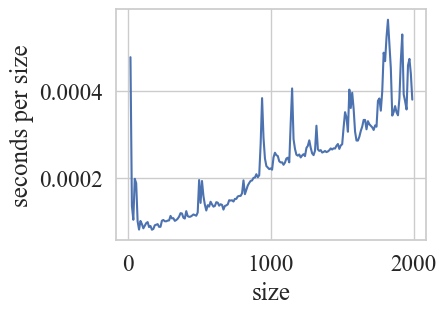

In [30]:
plt.figure(figsize=(4,3))
tdim['seconds per size'] = tdim['seconds'] / tdim['size']
sns.lineplot(data=tdim,x='size',y='seconds per size')
filepath = r"..\results\figures\FRU"
filename = os.path.join(filepath, 'time_complexity_FRU.pdf')
plt.savefig(filename, bbox_inches='tight', dpi=1000, format = 'pdf')
plt.show()

## 3. Toy example, thesis section 3.2

In [35]:
# unfair scenario 1
toydf1 = pd.DataFrame([
    [0.82, 0.94, 'white', 'admit'],         # high grades, both got it
    [0.83, 0.92, 'non-white', 'admit'],     # high grades, both got it
    [0.76, 0.85, 'non-white', 'not admit'], # medium grade, black did not get it
    [0.76, 0.85, 'white', 'admit'],         # medium grade, white did not get it
    [0.74, 0.85, 'non-white', 'not admit'], # medium grade, white got it
    [0.74, 0.95, 'white', 'admit'],         # medium grade, white got it - partial inconsistency
    [0.56, 0.64, 'non-white', 'not admit'], # low grade, white got it
    [0.57, 0.63, 'white', 'not admit']],    # low grade, black did not get it
    columns=['LSAT', 'GPA', 'race', 'admit']) 
toydf1.index = toydf1.index +1
unfair = ['fair', 'fair', 'unfair', 'fair', 'unfair', 'fair', 'fair', 'fair']

In [36]:
# base rates
(toydf1.groupby(['admit','race'])['admit'].count() / toydf1.groupby(['admit'])['race'].count()).round(2)

admit      race     
admit      non-white    0.25
           white        0.75
not admit  non-white    0.75
           white        0.25
dtype: float64

In [ ]:
toy = toydf1.copy()
toy['admit'] = toy['admit'].replace({'not admit':0, 'admit':1})

membership_dictonary = {}
numeric = list(toy.dtypes != 'object')
membership_dictonary['full'] = FRS_loop(toy.values, 0.5, 'Luka', 'Luka', 'radzikowska').regions()
for f in toy.columns[:-1]:
    tdf = toy.copy()
    tdf.pop(f)
    numeric = list(tdf.dtypes != 'object')
    membership_dictonary[f] = POS_prot, NEG_prot, BND_prot = FRS_loop(tdf.values, 0.5, 'Luka', 'Luka', 'radzikowska').regions()

toy['$\mu_{B_{k}}(x)$'] = membership_dictonary['full'][-1][0]
toy['$\mu_{B_{k} \neg f_{i}}(x)$'] = membership_dictonary['race'][-1][0]
toy['$\Delta_{B_{k}\neg f_{i}}(x)$'] = membership_dictonary['full'][-1][0] - membership_dictonary['race'][-1][0]
toy['fair'] = unfair

frus = []
for f in toy.columns[:3]:
    frus.append(((np.sum((membership_dictonary['full'][-1][0] - membership_dictonary[f][-1][0])**2))/len(toy))**0.5)

fru_toy = pd.DataFrame(frus).T
fru_toy.columns = toy.columns[:3]
fru_toy.index = ['FRU']
fru_toy.loc['FRU normalized',:] = fru_toy.loc['FRU',:] / fru_toy.loc['FRU',:].sum()

In [43]:
toy

,LSAT,GPA,race,admit,$\mu_{B_{k}}(x)$,$\mu_{B_{k} \neg f_{i}}(x)$,$\Delta_{B_{k}\neg f_{i}}(x)$,fair
1,0.82,0.94,white,1,0.755784,0.927743,-0.171960,fair
2,0.83,0.92,non-white,1,0.932394,0.932394,0.000000,fair
3,0.76,0.85,non-white,0,0.932394,1.000000,-0.067606,unfair
4,0.76,0.85,white,1,0.814647,1.000000,-0.185353,fair
5,0.74,0.85,non-white,0,0.923116,0.990050,-0.066933,unfair
6,0.74,0.95,white,1,0.782705,0.951229,-0.168525,fair
7,0.56,0.64,non-white,0,0.759572,0.814647,-0.055075,fair
8,0.57,0.63,white,0,0.814647,0.814647,0.000000,fair


In [45]:
fru_toy

,LSAT,GPA,race
FRU,0.074326,0.093926,0.114242
FRU normalized,0.263107,0.332488,0.404405


In [44]:
# group FRU
gFRU = []
for group in toy['race'].unique():
    delta_group = toy[toy['race'] == group]['$\Delta_{B_{k}\neg f_{i}}(x)$']
    groupFRU = (np.sum(delta_group**2)/toy['race'].value_counts()[group])**0.5
    gFRU.append(['group-FRU '+group,groupFRU])

gFRU = pd.DataFrame(gFRU)
gFRU = gFRU.set_index(0, drop=True).T
gFRU['group-FRU absolute difference'] = abs(gFRU['group-FRU non-white'] - gFRU['group-FRU white'])
gFRU['group-FRU ratio'] = gFRU['group-FRU non-white'] / gFRU['group-FRU white']

gFRUnorm = list(((gFRU[['group-FRU white', 'group-FRU non-white']] / (gFRU['group-FRU white'] + gFRU['group-FRU non-white']).values[0]).values)[0])
gFRUnorm.append(gFRUnorm[1]-gFRUnorm[0])
gFRUnorm.append(gFRUnorm[1]/gFRUnorm[0])
gFRU.loc[2,:] = gFRUnorm
gFRU.index = ['raw values', 'normalized values']
gFRU

<>:4: SyntaxWarning: invalid escape sequence '\D'
<>:4: SyntaxWarning: invalid escape sequence '\D'
C:\Users\lucp11124\AppData\Local\Temp\ipykernel_20524\3676967708.py:4: SyntaxWarning: invalid escape sequence '\D'
  delta_group = toy[toy['race'] == group]['$\Delta_{B_{k}\neg f_{i}}(x)$']


,group-FRU white,group-FRU non-white,group-FRU absolute difference,group-FRU ratio
raw values,0.151926,0.054964,0.096963,0.361778
normalized values,0.734334,0.265666,-0.468669,0.361778
